# Environmental Sound Classification

* this kernel is useful for any audio classification task.
* the following libraries are used in this kernel
    1. Tensorflow (for model making and training)
    2. sklearn (for splitting the data into trian,test,validation)
    3. librosa (for loading and feature extraction of audio signals)
    4. pandas (for reading csv file)
    5. matplotlib (for plotting)

>**Please upvote if you like my approach or if you learned something from this notebook.
Your support gives me motivation to create interesting stuff.
Thank you.**

## Step 1. Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

%matplotlib inline
%load_ext tensorboard

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Step 2. Loading and Preprocessing

In [3]:
CSV_FILE_PATH = "../input/environmental-sound-classification-50/esc50.csv"  # path of csv file
DATA_PATH = "../input/environmental-sound-classification-50/audio/audio/44100/" # path to folder containing audio files

In [4]:
#reading the csv file
df = pd.read_csv(CSV_FILE_PATH)
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


> Out of 50 classes we will be using 10 classes.
> dataframe has column "esc10" which contains 10 classes. So, we will be using that 10 classes only.

In [5]:
df_10 = df[df['esc10']==True]
df_10 = df_10.drop(['fold','esc10','src_file','take'], axis=1)
df_10

,filename,target,category
0,1-100032-A-0.wav,0,dog
14,1-110389-A-0.wav,0,dog
24,1-116765-A-41.wav,41,chainsaw
54,1-17150-A-12.wav,12,crackling_fire
55,1-172649-A-40.wav,40,helicopter
...,...,...,...
1876,5-233160-A-1.wav,1,rooster
1888,5-234879-A-1.wav,1,rooster
1889,5-234879-B-1.wav,1,rooster
1894,5-235671-A-38.wav,38,clock_tick


* editing target column according to the 10 classes.

In [6]:
classes = df_10['category'].unique()
classes

array(['dog', 'chainsaw', 'crackling_fire', 'helicopter', 'rain',
       'crying_baby', 'clock_tick', 'sneezing', 'rooster', 'sea_waves'],
      dtype=object)

In [7]:
class_dict = {i:x for x,i in enumerate(classes)}
class_dict

{'dog': 0,
 'chainsaw': 1,
 'crackling_fire': 2,
 'helicopter': 3,
 'rain': 4,
 'crying_baby': 5,
 'clock_tick': 6,
 'sneezing': 7,
 'rooster': 8,
 'sea_waves': 9}

In [8]:
df_10['target'] = df_10['category'].map(class_dict)
df_10

,filename,target,category
0,1-100032-A-0.wav,0,dog
14,1-110389-A-0.wav,0,dog
24,1-116765-A-41.wav,1,chainsaw
54,1-17150-A-12.wav,2,crackling_fire
55,1-172649-A-40.wav,3,helicopter
...,...,...,...
1876,5-233160-A-1.wav,8,rooster
1888,5-234879-A-1.wav,8,rooster
1889,5-234879-B-1.wav,8,rooster
1894,5-235671-A-38.wav,6,clock_tick


## Step 3. Visualization

* if you have little or no idea about mel-spectrogram and MFCC visit this site.
[Introduction to feature extraction](https://towardsdatascience.com/how-to-apply-machine-learning-and-deep-learning-methods-to-audio-analysis-615e286fcbbc)

In [9]:
from IPython.display import HTML
# Youtube
HTML('<iframe width="663" height="382" src="https://www.youtube.com/embed/1RIA9U5oXro" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


[](http://)

Taking one sample from each of the 10 classes for visualization

In [10]:
sample_df = df_10.drop_duplicates(subset=['target'])
sample_df

,filename,target,category
0,1-100032-A-0.wav,0,dog
24,1-116765-A-41.wav,1,chainsaw
54,1-17150-A-12.wav,2,crackling_fire
55,1-172649-A-40.wav,3,helicopter
62,1-17367-A-10.wav,4,rain
78,1-187207-A-20.wav,5,crying_baby
110,1-21934-A-38.wav,6,clock_tick
136,1-26143-A-21.wav,7,sneezing
141,1-26806-A-1.wav,8,rooster
148,1-28135-A-11.wav,9,sea_waves


In [11]:
signals = {}
mel_spectrograms = {}
mfccs = {}

for row in tqdm(sample_df.iterrows()):  # every row will be like [[index], [filename , target , category]]
    signal , rate = librosa.load(DATA_PATH+ row[1][0])
    signals[row[1][2]] = signal    # row[1][2] will be the category of that signal. eg. signal["dog"] = signal of dog sound
    
    mel_spec = librosa.feature.melspectrogram(y=signal , sr=rate ,  n_fft=2048, hop_length=512)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  #visualizing mel_spectrogram directly gives black image. So, coverting from power_to_db is required
    mel_spectrograms[row[1][2]] = mel_spec
    
    mfcc = librosa.feature.mfcc(signal , rate , n_mfcc=13, dct_type=3)
    mfccs[row[1][2]] = mfcc

10it [00:03,  2.95it/s]


In [12]:
def plot_signal(signal):
    """
    this function will take the signal dictionary and plot the signals
    """
    fig , axes = plt.subplots(nrows=5 , ncols=2 , sharex =False ,sharey=True,
                             figsize=(40,20))
    fig.suptitle('Time series',size=15)
    i=0
    for x in range(5):
        for y in range(2):
            axes[x,y].set_title(list(signal.keys())[i])
            axes[x,y].plot(list(signal.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

In [13]:
def dis_feature(mfccs, cmap=None):
    """
    this function will take the mfcc/mel_spectrogram dictionary and plot the signals
    """
    fig ,axes= plt.subplots(nrows=5 , ncols=2 , sharex=False, sharey=True , figsize=(40,20))
    fig.suptitle('mel')
    i=0
    for x in range(5):
        for y in range(2):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=cmap,interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

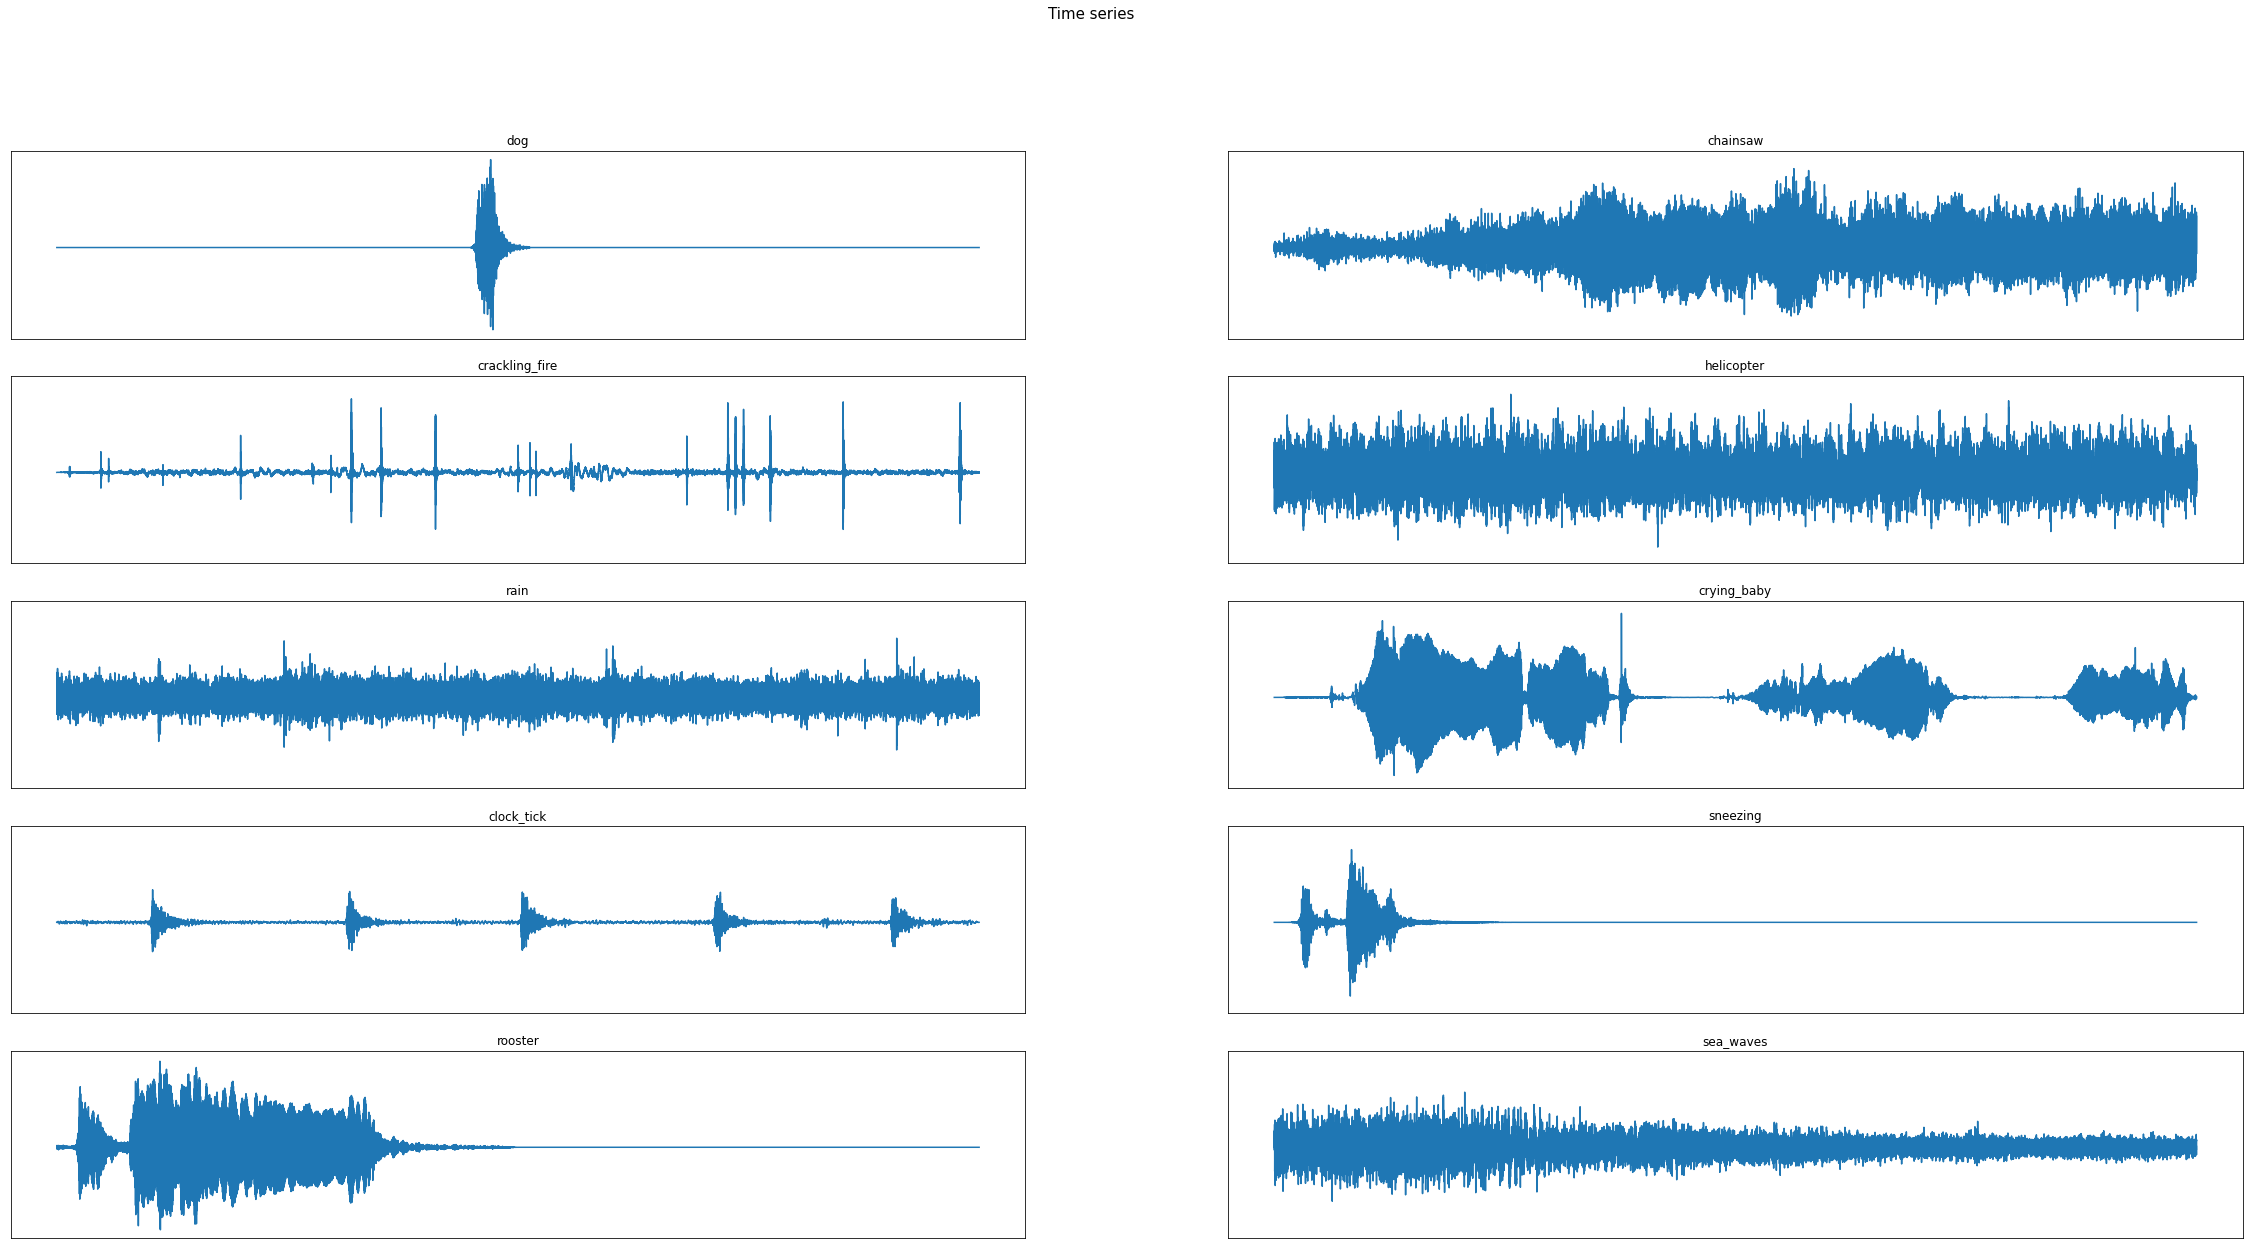

In [14]:
plot_signal(signals)

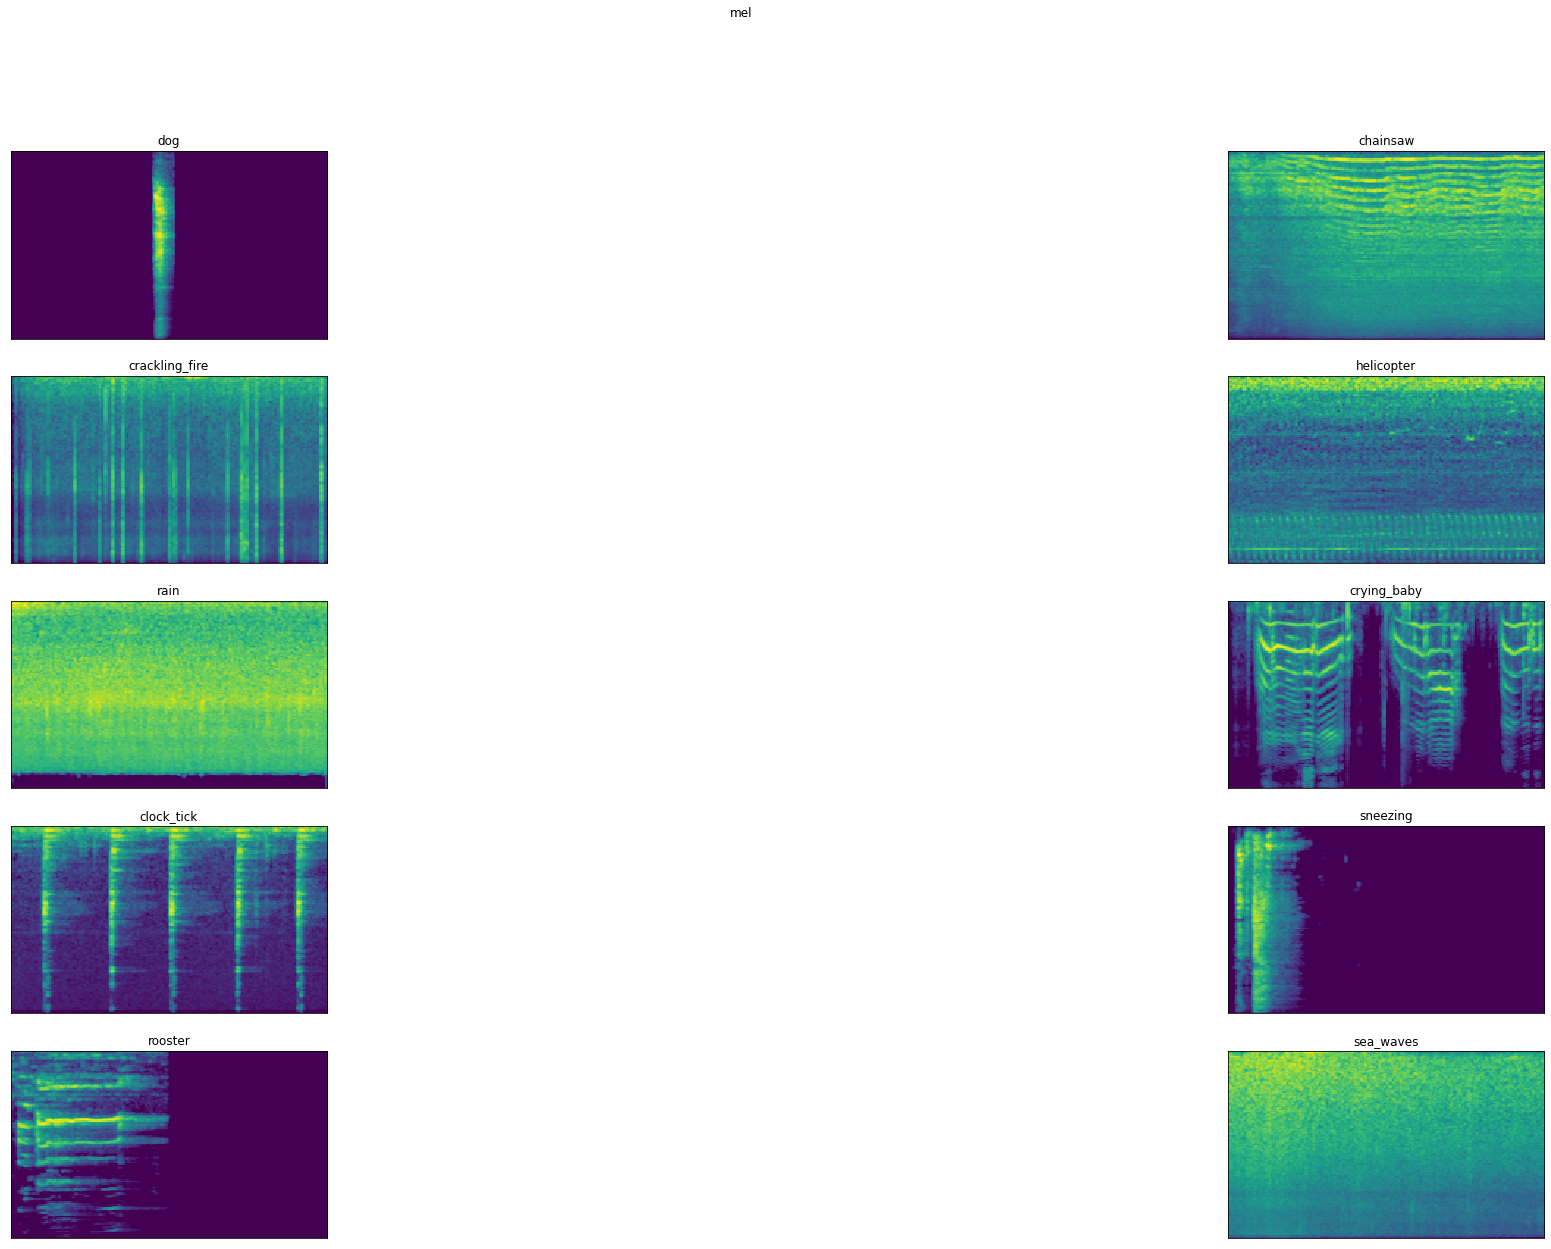

In [15]:
dis_feature(mel_spectrograms)

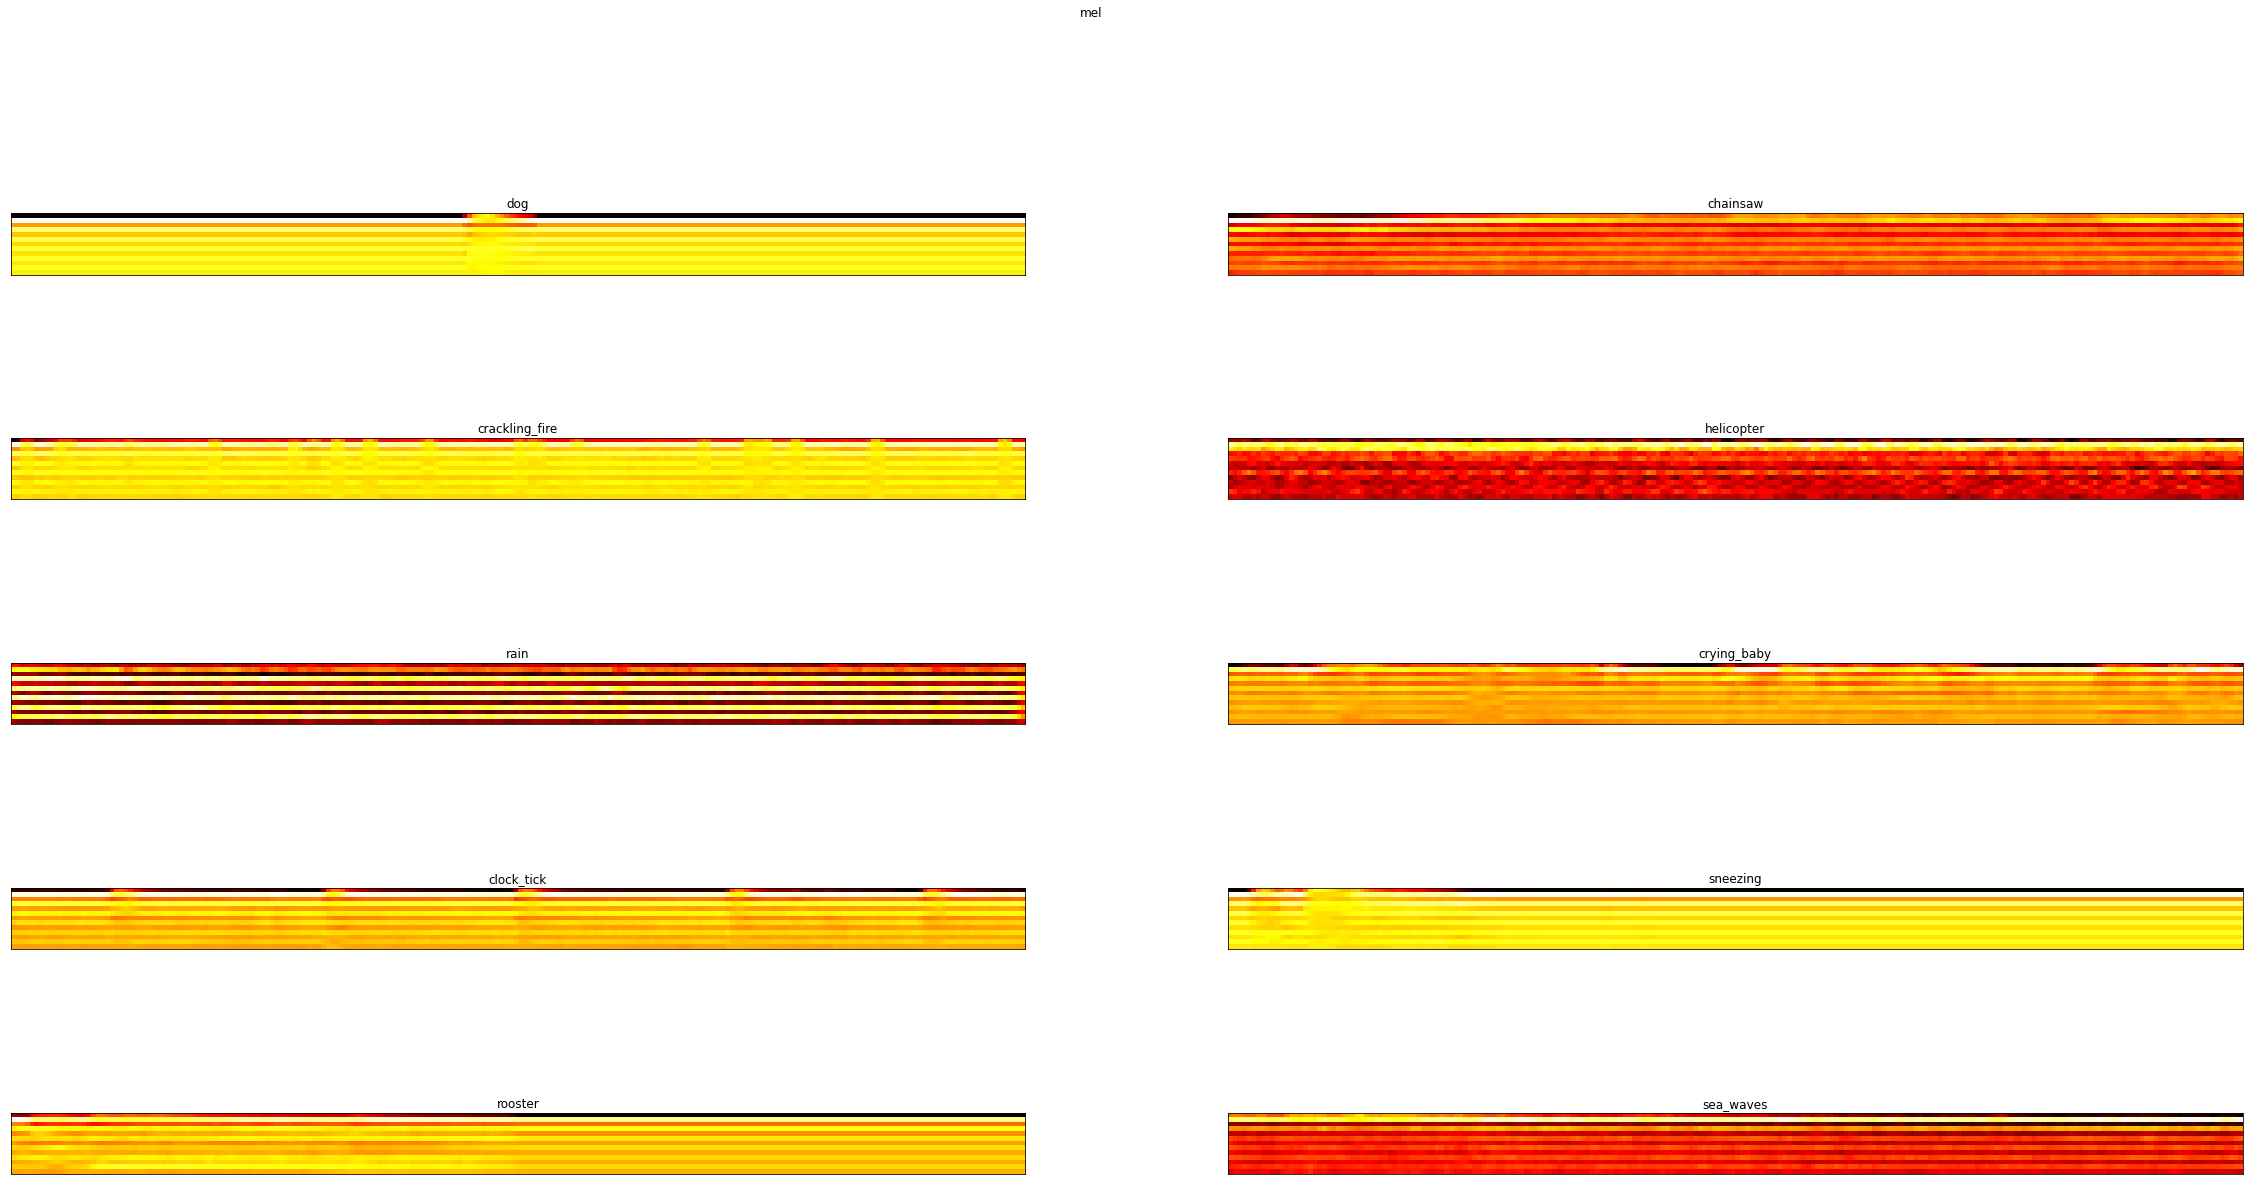

In [16]:
dis_feature(mfccs, cmap='hot')

> Here we extracted two features mel-spectrogram and mfcc.
> I had tried to use both feature for training and mfcc performed very well.
> So, here we are going to use mfcc for training.

## Step 4. Getting Data ready for training

* Now we are going to take a three random 2 second clip from each audio file. this will increase the data size and also classification speed increases.
* the following code iterate through every file and take three random clip from it.

In [17]:
X , y = [] , []
for data in tqdm(df_10.iterrows()):
  sig , sr = librosa.load(DATA_PATH+data[1][0])
  for i in range(3):
    n = np.random.randint(0, len(sig)-(sr*2))
    sig_ = sig[n : int(n+(sr*2))]
    mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
    X.append(mfcc_)
    y.append(data[1][1])

# convert list to numpy array
X = np.array(X) 
y = np.array(y)

#one-hot encoding the target
y = tf.keras.utils.to_categorical(y , num_classes=10)

# our tensorflow model takes input as (no_of_sample , height , width , channel).
# here X has dimension (no_of_sample , height , width).
# So, the below code will reshape it to (no_of_sample , height , width , 1).
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

400it [01:39,  4.02it/s]


In [18]:
X.shape
y.shape

(1200, 13, 87, 1)

(1200, 10)

In [19]:
x_train , x_val , y_train , y_val = train_test_split(X , y ,test_size=0.2, random_state=2020)

## Step 5. Model

In [20]:
INPUTSHAPE = (13,87,1)

In [21]:
model =  models.Sequential([
                          layers.Conv2D(16 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),
                          layers.Conv2D(16, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(64, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          layers.GlobalAveragePooling2D(),


                          layers.Dense(32 , activation = 'relu'),
                          layers.Dense(10 , activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 85, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 83, 16)         2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 81, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 79, 32)         9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 77, 64)         18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 75, 32)         18464     
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0

In [23]:
%mkdir "cpkt"
%mkdir "logs"

In [24]:
LOGDIR = "logs"
CPKT = "cpkt/"

In [25]:
#this callback is used to prevent overfitting.
callback_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

#this checkpoint saves the best weights of model at every epoch
callback_2 = tf.keras.callbacks.ModelCheckpoint(
    CPKT, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None
)

#this is for tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOGDIR)


In [26]:
history = model.fit(x_train,y_train ,
            validation_data=(x_val,y_val),
            epochs=100,
            callbacks = [callback_1 , callback_2 , tensorboard_callback])

Epoch 1/100
30/30 [==============================] - 2s 73ms/step - loss: 1.9593 - acc: 0.2812 - val_loss: 1.5840 - val_acc: 0.4792
Epoch 2/100
30/30 [==============================] - 2s 64ms/step - loss: 1.4519 - acc: 0.4948 - val_loss: 1.1527 - val_acc: 0.6500
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 1.0934 - acc: 0.6427 - val_loss: 1.1105 - val_acc: 0.6167
Epoch 4/100
30/30 [==============================] - 2s 61ms/step - loss: 0.8959 - acc: 0.6990 - val_loss: 0.8718 - val_acc: 0.6792
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.7258 - acc: 0.7437 - val_loss: 0.8956 - val_acc: 0.7083
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6593 - acc: 0.7604 - val_loss: 0.7525 - val_acc: 0.7500
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6083 - acc: 0.7771 - val_loss: 0.6892 - val_acc: 0.7708
Epoch 8/100
30/30 [==============================] - 2s 60ms/step - loss: 0.

if running this in google colab use the following code:

In [27]:
# %tensorboard --logdir="logs"

if running in kaggle kernel use this code.
there are some error displaying tensorboard. So,the below code is taken from this amazing kernel.(https://www.kaggle.com/shivam1600/tensorboard-on-kaggle)

In [28]:
# Download Ngrok to tunnel the tensorboard port to an external port
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# Run tensorboard as well as Ngrox (for tunneling as non-blocking processes)
import os
import multiprocessing


pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir=\"logs\" --host 0.0.0.0 --port 6006 &",
                        "./ngrok http 6006 &"
                        ]]

--2020-09-02 08:45:18--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.71.209.190, 54.159.87.23, 52.5.250.138, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.71.209.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  17.0MB/s    in 0.8s    

2020-09-02 08:45:19 (17.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


> use the link in the output of the following section to view in tensorboard.

In [29]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://02060b601132.ngrok.io
